Tutorial 3 - Dynamic Flowsheets
=============================

Introduction
------------


<img src="mix_2cstrs.png">

<center>ethyl acetate + NaOH $\rightarrow$ sodium acetate + ethanol</center>

In this tutorial, you will learn how to:

* do stuff

In [1]:
import matplotlib.pyplot as plt

# Import Pyomo libraries
from pyomo.environ import (ConcreteModel, SolverFactory, TransformationFactory,
                           Var, Constraint)
from pyomo.network import Arc

# Import IDAES core
from idaes.core import FlowsheetBlock

# Import Unit Model Modules
import idaes.property_models.examples.saponification_thermo as thermo_props
import idaes.property_models.examples.saponification_reactions as \
    reaction_props

# Import Unit Model Modules
from idaes.unit_models import CSTR, Mixer

In [2]:
m = ConcreteModel()

In [3]:
m.fs = FlowsheetBlock(default={"dynamic": True, "time_set": [0, 1, 8]})

In [4]:
m.fs.thermo_params = thermo_props.SaponificationParameterBlock()
m.fs.reaction_params = reaction_props.SaponificationReactionParameterBlock(
    default={"property_package": m.fs.thermo_params})

In [5]:
m.fs.mix = Mixer(default={"dynamic": False,
                          "property_package": m.fs.thermo_params})

In [6]:
m.fs.Tank1 = CSTR(default={"property_package": m.fs.thermo_params,
                           "reaction_package": m.fs.reaction_params,
                           "has_holdup": True,
                           "has_equilibrium_reactions": False,
                           "has_heat_transfer": True,
                           "has_pressure_change": False,
                           "dynamic": False})
m.fs.Tank2 = CSTR(default={"property_package": m.fs.thermo_params,
                           "reaction_package": m.fs.reaction_params,
                           "has_holdup": True,
                           "has_equilibrium_reactions": False,
                           "has_heat_transfer": True,
                           "has_pressure_change": False})

2019-03-20 16:25:05 - INFO - idaes.core.control_volume0d - fs.Tank1.control_volume add_total_pressure_balances was provided with argument has_holdup = True. Total pressure balances do not support holdup terms (yet), and this argument will be ignored.
2019-03-20 16:25:05 - INFO - idaes.core.control_volume0d - fs.Tank2.control_volume add_total_pressure_balances was provided with argument dynamic = True. Total pressure balances do not support dynamic terms (yet), and this argument will be ignored.
2019-03-20 16:25:05 - INFO - idaes.core.control_volume0d - fs.Tank2.control_volume add_total_pressure_balances was provided with argument has_holdup = True. Total pressure balances do not support holdup terms (yet), and this argument will be ignored.


In [7]:
m.fs.Tank1.height = Var(m.fs.time,
                        initialize=1.0,
                        doc="Depth of fluid in tank [m]")
m.fs.Tank1.area = Var(initialize=1.0,
                      doc="Cross-sectional area of tank [m^2]")
m.fs.Tank1.flow_coeff = Var(m.fs.time,
                            initialize=5e-5,
                            doc="Tank outlet flow coefficient")

In [8]:
def geometry(b, t):
    return b.volume[t] == b.area*b.height[t]
m.fs.Tank1.geometry = Constraint(m.fs.time, rule=geometry)

In [9]:
def outlet_flowrate(b, t):
    return b.control_volume.properties_out[t].flow_vol == b.flow_coeff[t]*b.height[t]
m.fs.Tank1.outlet_flowrate = Constraint(m.fs.time, rule=outlet_flowrate)

In [10]:
m.fs.Tank2.height = Var(m.fs.time,
                        initialize=1.0,
                        doc="Depth of fluid in tank [m]")
m.fs.Tank2.area = Var(initialize=1.0,
                      doc="Cross-sectional area of tank [m^2]")
m.fs.Tank2.flow_coeff = Var(m.fs.time,
                            initialize=5e-5,
                            doc="Tank outlet flow coefficient")

m.fs.Tank2.geometry = Constraint(m.fs.time, rule=geometry)
m.fs.Tank2.outlet_flowrate = Constraint(m.fs.time, rule=outlet_flowrate)

In [11]:
m.fs.stream1 = Arc(source=m.fs.mix.outlet, destination=m.fs.Tank1.inlet)
m.fs.stream2 = Arc(source=m.fs.Tank1.outlet, destination=m.fs.Tank2.inlet)

In [12]:
m.discretizer = TransformationFactory('dae.finite_difference')
m.discretizer.apply_to(m,
                       nfe=200,
                       wrt=m.fs.time,
                       scheme="BACKWARD")

In [13]:
TransformationFactory("network.expand_arcs").apply_to(m)

In [14]:
m.fs.mix.inlet_1.flow_vol.fix(0.5)
m.fs.mix.inlet_1.conc_mol_comp[:, "H2O"].fix(55388.0)
m.fs.mix.inlet_1.conc_mol_comp[:, "NaOH"].fix(100.0)
m.fs.mix.inlet_1.conc_mol_comp[:, "EthylAcetate"].fix(0.0)
m.fs.mix.inlet_1.conc_mol_comp[:, "SodiumAcetate"].fix(0.0)
m.fs.mix.inlet_1.conc_mol_comp[:, "Ethanol"].fix(0.0)
m.fs.mix.inlet_1.temperature.fix(303.15)
m.fs.mix.inlet_1.pressure.fix(101325.0)

m.fs.mix.inlet_2.flow_vol.fix(0.5)
m.fs.mix.inlet_2.conc_mol_comp[:, "H2O"].fix(55388.0)
m.fs.mix.inlet_2.conc_mol_comp[:, "NaOH"].fix(0.0)
m.fs.mix.inlet_2.conc_mol_comp[:, "EthylAcetate"].fix(100.0)
m.fs.mix.inlet_2.conc_mol_comp[:, "SodiumAcetate"].fix(0.0)
m.fs.mix.inlet_2.conc_mol_comp[:, "Ethanol"].fix(0.0)
m.fs.mix.inlet_2.temperature.fix(303.15)
m.fs.mix.inlet_2.pressure.fix(101325.0)

In [15]:
m.fs.Tank1.area.fix(1.0)
m.fs.Tank1.flow_coeff.fix(0.5)
m.fs.Tank1.heat_duty.fix(0.0)

m.fs.Tank2.area.fix(1.0)
m.fs.Tank2.flow_coeff.fix(0.5)
m.fs.Tank2.heat_duty.fix(0.0)

In [16]:
m.fs.fix_initial_conditions()

In [17]:
m.fs.mix.initialize()

{'inlet_1': {'Fflag': {0.0: True,
   0.03125: True,
   0.0625: True,
   0.09375: True,
   0.125: True,
   0.15625: True,
   0.1875: True,
   0.21875: True,
   0.25: True,
   0.28125: True,
   0.3125: True,
   0.34375: True,
   0.375: True,
   0.40625: True,
   0.4375: True,
   0.46875: True,
   0.5: True,
   0.53125: True,
   0.5625: True,
   0.59375: True,
   0.625: True,
   0.65625: True,
   0.6875: True,
   0.71875: True,
   0.75: True,
   0.78125: True,
   0.8125: True,
   0.84375: True,
   0.875: True,
   0.90625: True,
   0.9375: True,
   0.96875: True,
   1.0: True,
   1.027344: True,
   1.054688: True,
   1.109375: True,
   1.164062: True,
   1.191406: True,
   1.21875: True,
   1.246094: True,
   1.273438: True,
   1.328125: True,
   1.382812: True,
   1.410156: True,
   1.4375: True,
   1.464844: True,
   1.492188: True,
   1.546875: True,
   1.601562: True,
   1.628906: True,
   1.65625: True,
   1.683594: True,
   1.710938: True,
   1.765625: True,
   1.820312: True,
   1.8

In [18]:
m.fs.Tank1.initialize(state_args={
            "flow_vol": m.fs.mix.outlet.flow_vol[0].value,
            "conc_mol_comp": {"H2O": m.fs.mix.outlet.conc_mol_comp[0, "H2O"].value,
                              "NaOH": m.fs.mix.outlet.conc_mol_comp[0, "NaOH"].value,
                              "EthylAcetate": m.fs.mix.outlet.conc_mol_comp[0, "EthylAcetate"].value,
                              "SodiumAcetate": m.fs.mix.outlet.conc_mol_comp[0, "SodiumAcetate"].value,
                              "Ethanol": m.fs.mix.outlet.conc_mol_comp[0, "Ethanol"].value},
            "temperature": m.fs.mix.outlet.temperature[0].value,
            "pressure": m.fs.mix.outlet.pressure[0].value})

In [19]:
m.fs.Tank2.initialize(state_args={
            "flow_vol": m.fs.Tank1.outlet.flow_vol[0].value,
            "conc_mol_comp": {"H2O": m.fs.Tank1.outlet.conc_mol_comp[0, "H2O"].value,
                              "NaOH": m.fs.Tank1.outlet.conc_mol_comp[0, "NaOH"].value,
                              "EthylAcetate": m.fs.Tank1.outlet.conc_mol_comp[0, "EthylAcetate"].value,
                              "SodiumAcetate": m.fs.Tank1.outlet.conc_mol_comp[0, "SodiumAcetate"].value,
                              "Ethanol": m.fs.Tank1.outlet.conc_mol_comp[0, "Ethanol"].value},
            "temperature": m.fs.Tank1.outlet.temperature[0].value,
            "pressure": m.fs.Tank1.outlet.pressure[0].value})

In [20]:
solver = SolverFactory('ipopt')
results = solver.solve(m.fs)

In [21]:
for t in m.fs.time:
    if t > 1.0:
        m.fs.mix.inlet_2.conc_mol_comp[t, "EthylAcetate"].fix(90.0)
results = solver.solve(m.fs)

In [22]:
print(results)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 16074
  Number of variables: 16074
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.12.6\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.13831734657287598
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [23]:
time = []
a1 = []
b1 = []
c1 = []
d1 = []
a2 = []
b2 = []
c2 = []
d2 = []

for t in m.fs.time:
    time.append(t)
    a1.append(m.fs.Tank1.outlet.conc_mol_comp[t, "NaOH"].value)
    b1.append(m.fs.Tank1.outlet.conc_mol_comp[t, "EthylAcetate"].value)
    c1.append(m.fs.Tank1.outlet.conc_mol_comp[t, "SodiumAcetate"].value)
    d1.append(m.fs.Tank1.outlet.conc_mol_comp[t, "Ethanol"].value)
    a2.append(m.fs.Tank2.outlet.conc_mol_comp[t, "NaOH"].value)
    b2.append(m.fs.Tank2.outlet.conc_mol_comp[t, "EthylAcetate"].value)
    c2.append(m.fs.Tank2.outlet.conc_mol_comp[t, "SodiumAcetate"].value)
    d2.append(m.fs.Tank2.outlet.conc_mol_comp[t, "Ethanol"].value)

Text(0, 0.5, 'Concentration [mol/m^3]')

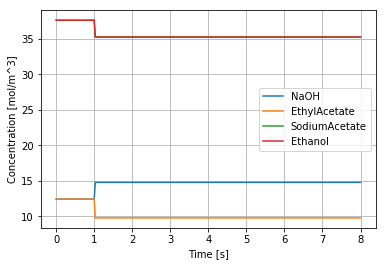

In [24]:
plt.figure("Tank 1 Outlet")
plt.plot(time, a1, label='NaOH')
plt.plot(time, b1, label='EthylAcetate')
plt.plot(time, c1, label='SodiumAcetate')
plt.plot(time, d1, label='Ethanol')
plt.legend()
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Concentration [mol/m^3]")

Text(0, 0.5, 'Concentration [mol/m^3]')

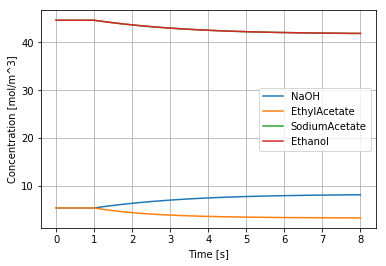

In [25]:
plt.figure("Tank 2 Outlet")
plt.plot(time, a2, label='NaOH')
plt.plot(time, b2, label='EthylAcetate')
plt.plot(time, c2, label='SodiumAcetate')
plt.plot(time, d2, label='Ethanol')
plt.legend()
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Concentration [mol/m^3]")